# MotiHomeT: Algorithm

### Import Libraries

In [1]:
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit as sigmoid
import tensorflow as tf

### Base Settings

In [2]:
SAMPLE_INTERVAL = 30 # ms

BODY_PARTS = [
    'NOSE',
    'LEFT_EYE',
    'RIGHT_EYE',
    'LEFT_EAR',
    'RIGHT_EAR',
    'LEFT_SHOULDER',
    'RIGHT_SHOULDER',
    'LEFT_ELBOW',
    'RIGHT_ELBOW',
    'LEFT_WRIST',
    'RIGHT_WRIST',
    'LEFT_HIP',
    'RIGHT_HIP',
    'LEFT_KNEE',
    'RIGHT_KNEE',
    'LEFT_ANKLE',
    'RIGHT_ANKLE',
]

USING_PARTS = [
    'SHOULDER',
    'WRIST',
    'HIP',
    'KNEE',
    'ANKLE',
]

BODY_JOINTS = [
    ('LEFT_WRIST', 'LEFT_ELBOW'),
    ('LEFT_ELBOW', 'LEFT_SHOULDER'),
    ('LEFT_SHOULDER', 'RIGHT_SHOULDER'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'),
    ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('LEFT_SHOULDER', 'LEFT_HIP'),
    ('LEFT_HIP', 'RIGHT_HIP'),
    ('RIGHT_HIP', 'RIGHT_SHOULDER'),
    ('LEFT_HIP', 'LEFT_KNEE'),
    ('LEFT_KNEE', 'LEFT_ANKLE'),
    ('RIGHT_HIP', 'RIGHT_KNEE'),
    ('RIGHT_KNEE', 'RIGHT_ANKLE')
]

NUM_BODY_PARTS = len(BODY_PARTS)
BODY_PART_TO_IDX = {body_part:idx for idx, body_part in enumerate(BODY_PARTS)}
IDX_TO_BODY_PART = {idx:body_part for idx, body_part in enumerate(BODY_PARTS)}
BODY_JOINTS_IDX = [(BODY_PART_TO_IDX[joint1], BODY_PART_TO_IDX[joint2]) for joint1, joint2 in BODY_JOINTS]

### Load Functions

In [3]:
def get_pushup_types(person: str):
    return [dirpath.split('/')[-1] for dirpath in glob(f'{person}_processed/*')]
    

def get_framenums(person: str, pushup_type: str):
    filepaths = glob(f'{person}_processed/{pushup_type}/*.png')
    return sorted([int(filepath.split('/')[-1][:-4]) for filepath in filepaths])

def get_image(person: str, pushup_type: str, framenum: int):
    image_path = f'{person}_processed/{pushup_type}/{framenum}.png'
    img = cv2.imread(image_path)[:,:,[2,1,0]]
    return img


persons = ['hyunwoo', 'changmin']
pushup_types_dict = {person: get_pushup_types(person) for person in persons}
framenums_dict = {(person, pushup_type): get_framenums(person, pushup_type)
    for person in persons for pushup_type in pushup_types_dict[person]}

### Inference with TensorFlow Lite

In [4]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="posenet_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

def inference(img: np.ndarray, rotate: bool = True) -> np.ndarray:
    if rotate:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    img = img.astype(np.float)
    img = (img - 128) / 128
    
    # Test the model on random input data.
    input_data = np.array(img, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data.reshape(input_shape))

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    heatmaps = interpreter.get_tensor(output_details[0]['index'])
    offsets = interpreter.get_tensor(output_details[1]['index'])

    height = heatmaps[0].shape[0]
    width = heatmaps[0][0].shape[0]
    num_keypoints = heatmaps[0][0][0].shape[0]

    keypoint_positions = []
    for keypoint in range(num_keypoints):
        max_val = heatmaps[0][0][0][keypoint]
        max_row = 0
        max_col = 0
        for row in range(height):
            for col in range(width):
                if heatmaps[0][row][col][keypoint] > max_val:
                    max_val = heatmaps[0][row][col][keypoint]
                    max_row = row
                    max_col = col
        keypoint_positions.append((max_row, max_col))

    result = []
    for i, (y_idx, x_idx) in enumerate(keypoint_positions):
        y_pos = int(y_idx / (height - 1) * img.shape[0] + offsets[0][y_idx][x_idx][i])
        x_pos = int(x_idx / (width - 1) * img.shape[1] + offsets[0][y_idx][x_idx][i + num_keypoints])
        confidence_score = sigmoid(heatmaps[0][y_idx][x_idx][i])

        if rotate:
            result.append((y_pos, img.shape[1] - x_pos, confidence_score))
        else:
            result.append((x_pos, y_pos, confidence_score))
    return np.asarray(result)

### Visualization

In [5]:
def draw_skeleton(inference_result, ax):
    for x, y, score in inference_result:
        ax.scatter(x, y, color='r')
    
    for joint1, joint2 in BODY_JOINTS_IDX:
        x1, y1, score1 = inference_result[joint1]
        x2, y2, score2 = inference_result[joint2]
        ax.plot([x1, x2], [y1, y2], color='r')

### Test

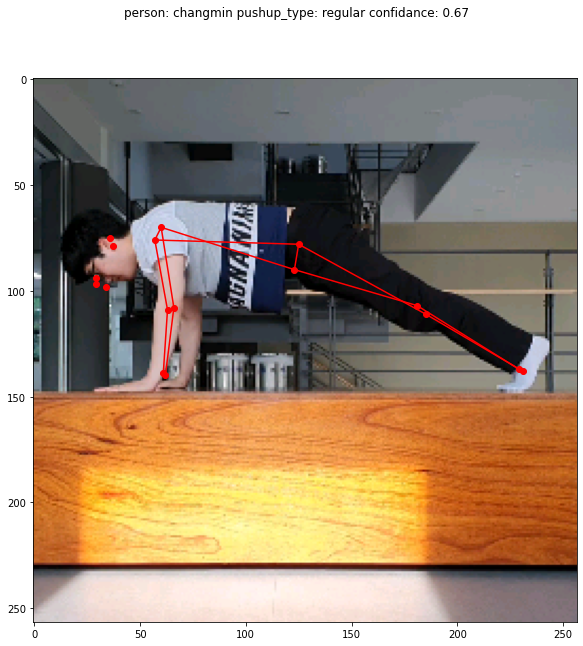

In [6]:
person = 'changmin'
pushup_type = 'regular'

fig, ax = plt.subplots(figsize=(10,10))

img = get_image(person, pushup_type, 0)
ax.imshow(img)
result = inference(img)
draw_skeleton(result, ax)

fig.suptitle(f'person: {person} pushup_type: {pushup_type} confidance: {np.average(result[:,2]) :.2f}')
plt.show()

### Function for Inference Images

In [7]:
def get_pos_sequence(person, pushup_type):
    framenums = get_framenums(person, pushup_type)
    results = []
    for frame in framenums:
        img = get_image(person, pushup_type, frame)
        result = inference(img)[np.newaxis, ...]
        results.append(result)
    return np.vstack(results)

### Inference or Load

In [8]:
import os
import pickle

save_filename = 'pos_sequences.pkl'
if os.path.exists(save_filename):
    with open(save_filename, 'rb') as f:
        pos_sequences = pickle.load(f)
else:
    pos_sequences = {}
    for person in persons:
        for pushup_type in get_pushup_types(person):
            pos_sequences[(person, pushup_type)] = get_pos_sequence(person, pushup_type)
    
    with open(save_filename, 'wb') as f:
        pickle.dump(pos_sequences, f)

### Loaded data

In [9]:
for key, value in pos_sequences.items():
    print(key, np.average(value[:,:,2]))

('hyunwoo', 'frontal_view') 0.35975166327126246
('hyunwoo', 'false_medium') 0.7292700781432512
('hyunwoo', 'left_side_arm') 0.1669106646339626
('hyunwoo', 'regular') 0.7349275858455019
('hyunwoo', 'degree_45_wide') 0.6699818624919994
('hyunwoo', 'both_side_arm') 0.25126538553415356
('hyunwoo', 'false_knee_on_bottom') 0.7407336155575033
('hyunwoo', 'table') 0.1202783928847804
('hyunwoo', 'false_wall') 0.3272803820053184
('hyunwoo', 'false_form') 0.6986463595271543
('hyunwoo', 'false_laying_on_floor') 0.6840494565854522
('hyunwoo', 'degree_45_narrow') 0.6256110562359022
('hyunwoo', 'rear_view') 0.32355414892810236
('hyunwoo', 'false_small') 0.7024933954565955
('changmin', 'frontal_view') 0.28730312940865577
('changmin', 'false_medium') 0.6777364537650808
('changmin', 'narrow') 0.6955656634616421
('changmin', 'left_side_arm') 0.2825648836422106
('changmin', 'regular') 0.6456204209003656
('changmin', 'degree_45_wide') 0.5408346180646475
('changmin', 'both_side_arm') 0.3314710037006087
('ch

# Pushup Counter class

In [10]:
from collections import deque

    
class PushupCounter:
    def __init__(self):
        self.idx = None
        self.inference_result = None
        
        # Posenet Calibration
        self.direction = None # LEFT or RIGHT
        self.window_size = 1000 // SAMPLE_INTERVAL
        self.unit_lengths = deque()
        self.calibrated_unit_length = None
        self.y_shoulders = deque()
        self.calibrated_y_shoulder = None
        
        # Count Calibration
        self.total_count = 0
        self.error_count = 0
        
        # Thresholds
        self.confidence_threshold = 0.5
        self.shoulder_distance_threshold = 1/6
        self.error_rate_threshold = 0.5
        
        # Count
        self.num_count = 0
        self.y_max = 0
        self.y_min = 1000
        self.count_y_shoulder_threshold = 1/5
        self.down_check = False
    
    
    def count(self, inference_result, idx=0) -> int:
        self.idx = idx
        self.inference_result = inference_result
        self._initialize_values()

        self.total_count += 1
        if self._is_camera_error(): # Check camera error
            self.error_count += 1
        elif self._is_pose_error(): # Check pose error
            self.error_count += 1
        else: # No error
            self._check_state()
        
        return self.num_count
    
    
    def _is_camera_error(self) -> bool:
        # Check confidence
        num_high_confidence_parts = np.sum([self._get_score(f'{self.direction}_{body_part}') > self.confidence_threshold
                                            for body_part in USING_PARTS])
        if len(USING_PARTS) - num_high_confidence_parts > 1:
            print(f'{self.idx} Camera Error: confidence error, {len(USING_PARTS)} - {num_high_confidence_parts} > 1')
            return True
        
        # Check distance between shoulders
        l_pos = self._get_xy('LEFT_SHOULDER')
        r_pos = self._get_xy('RIGHT_SHOULDER')
        if np.linalg.norm(l_pos - r_pos) > self.shoulder_distance_threshold * self.calibrated_unit_length:
            print(f'{self.idx} Camera Error: shoulder distance error, {np.linalg.norm(l_pos - r_pos)}')
            return True
        return False
    
    
    def _is_pose_error(self) -> bool:
        body_angle = self._calc_angle('WRIST', 'ANKLE', 'SHOULDER')
        if not (5 < body_angle and body_angle < 30):
            print(f'{self.idx} Pose Error: body angle error, {body_angle}')
            return True
        
        hip_angle = self._calc_angle('KNEE', 'HIP', 'SHOULDER')
        if not (135 < hip_angle and hip_angle < 180):
            print(f'{self.idx} Pose Error: hip angle error, {hip_angle}')
            return True
        
        knee_angle = self._calc_angle('ANKLE', 'KNEE', 'HIP')
        if not (150 < knee_angle and knee_angle < 210):
            print(f'{self.idx} Pose Error: knee angle error, {knee_angle}')
            return True
        return False
        
    
    def _check_state(self) -> bool:
        if self.y_max < self.calibrated_y_shoulder:
            self.y_max = self.calibrated_y_shoulder
        if self.y_min > self.calibrated_y_shoulder:
            self.y_min = self.calibrated_y_shoulder
        if self.y_max - self.y_min > self.count_y_shoulder_threshold * self.calibrated_unit_length:
            if self.down_check and self.y_min != self.calibrated_y_shoulder:
                if self.error_count / self.total_count < self.error_rate_threshold:
                    self.num_count += 1
                self.total_count = 0
                self.error_count = 0
            else:
                self.down_check = True
            self.y_min = self.calibrated_y_shoulder
            self.y_max = self.calibrated_y_shoulder
    
    
    def _initialize_values(self):
        self.direction = self._get_direction()
        self.calibrated_unit_length = self._get_unit_length()
        self.calibrated_y_shoulder = self._get_y_shoulder()
    

    def _get_direction(self) -> str:
        x_shoulder = np.average([self._get_xy(body_part)[0] for body_part in ['LEFT_SHOULDER', 'RIGHT_SHOULDER']])
        x_ankle = np.average([self._get_xy(body_part)[0] for body_part in ['LEFT_ANKLE', 'RIGHT_ANKLE']])
        if x_ankle > x_shoulder:
            return 'LEFT'
        else:
            return 'RIGHT'


    def _get_unit_length(self) -> float:
        pos_shoulder = self._get_xy(f'{self.direction}_SHOULDER')
        pos_hip = self._get_xy(f'{self.direction}_HIP')
        pos_knee = self._get_xy(f'{self.direction}_KNEE')
        pos_ankle = self._get_xy(f'{self.direction}_KNEE')
        unit_length = np.linalg.norm(pos_shoulder-pos_hip) + np.linalg.norm(pos_hip-pos_knee) + np.linalg.norm(pos_knee-pos_ankle)
        self.unit_lengths.append(unit_length)
        if len(self.unit_lengths) > self.window_size:
            self.unit_lengths.popleft()
        return sorted(self.unit_lengths)[min(len(self.unit_lengths), self.window_size)//2]


    def _get_y_shoulder(self) -> float:
        y_shoulder = self._get_xy(f'{self.direction}_SHOULDER')[1]
        self.y_shoulders.append(y_shoulder)
        if len(self.y_shoulders) > self.window_size:
            self.y_shoulders.popleft()
        return sorted(self.y_shoulders)[min(len(self.y_shoulders), self.window_size)//2]
        
        
    # Utils
    def _get_xy(self, body_part: str) -> (float, float):
        return self.inference_result[BODY_PART_TO_IDX[body_part], [0,1]]
        
        
    def _get_score(self, body_part: str) -> float:
        return self.inference_result[BODY_PART_TO_IDX[body_part], 2]
    
    
    def _calc_angle(self, body_part1: str, body_part2: str, body_part3: str) -> float:
        '''
        return point1 - point2 - point3
          LEFT: ClockWise angle
          RIGHT: CounterClockWise angle
            (degree: 0~360)
        '''
        pos1 = self._get_xy(f'{self.direction}_{body_part1}')
        pos2 = self._get_xy(f'{self.direction}_{body_part2}')
        pos3 = self._get_xy(f'{self.direction}_{body_part3}')
        v21 = pos1-pos2
        v23 = pos3-pos2
        cos = np.sum(v21*v23)/(np.linalg.norm(v21)*np.linalg.norm(v23))
        theta = np.rad2deg(np.arccos(cos))
        if (pos2[0]-pos1[0])*(pos3[1]-pos1[1])-(pos2[1]-pos1[1])*(pos3[0]-pos1[0]) > 0:
            return 360-theta if self.direction == 'LEFT' else theta
        else:
            return theta if self.direction == 'LEFT' else 360-theta

### Test

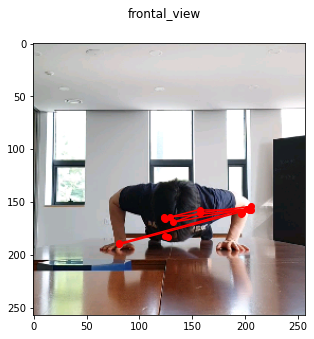

0 Camera Error: confidence error, 5 - 2 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 1 > 1
4 Camera Error: confidence error, 5 - 0 > 1
5 Camera Error: confidence error, 5 - 1 > 1
6 Camera Error: confidence error, 5 - 1 > 1
7 Camera Error: confidence error, 5 - 1 > 1
8 Camera Error: confidence error, 5 - 2 > 1
9 Camera Error: confidence error, 5 - 2 > 1
10 Camera Error: confidence error, 5 - 2 > 1
11 Camera Error: confidence error, 5 - 1 > 1
12 Camera Error: confidence error, 5 - 0 > 1
13 Camera Error: confidence error, 5 - 1 > 1
14 Camera Error: confidence error, 5 - 1 > 1
15 Camera Error: confidence error, 5 - 0 > 1
16 Camera Error: confidence error, 5 - 2 > 1
17 Camera Error: confidence error, 5 - 2 > 1
18 Camera Error: confidence error, 5 - 1 > 1
19 Camera Error: confidence error, 5 - 1 > 1
20 Camera Error: confidence error, 5 - 2 > 1
21 Camera Error: confidence error, 5 - 3 > 1
22 Camera Error: con

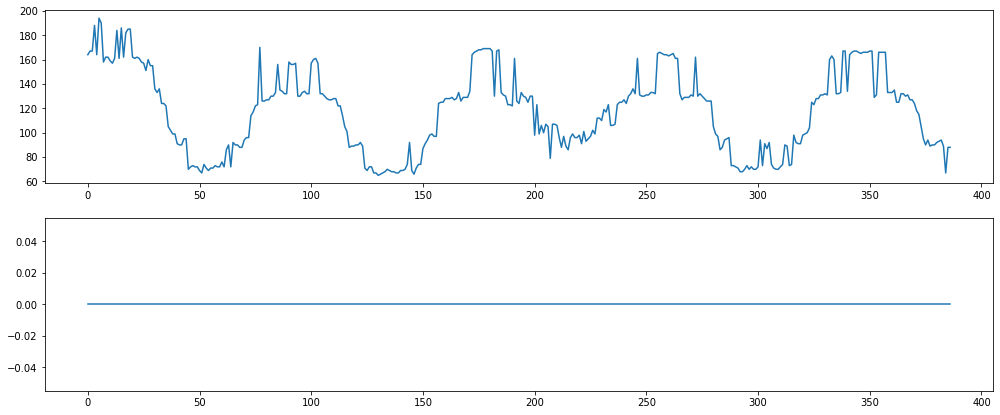

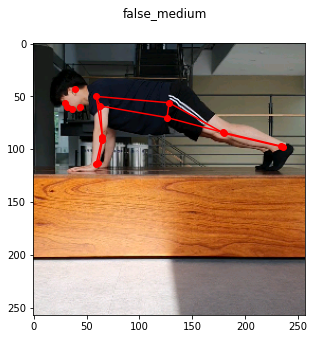

16 Camera Error: shoulder distance error, 24.041630560342615
17 Camera Error: shoulder distance error, 24.73863375370596
32 Camera Error: shoulder distance error, 22.847319317591726
34 Camera Error: shoulder distance error, 26.248809496813376
35 Camera Error: shoulder distance error, 29.410882339705484
36 Camera Error: shoulder distance error, 29.427877939124322
37 Camera Error: shoulder distance error, 22.360679774997898
50 Camera Error: shoulder distance error, 24.041630560342615
51 Camera Error: shoulder distance error, 25.632011235952593
56 Camera Error: shoulder distance error, 24.041630560342615
57 Camera Error: shoulder distance error, 25.0
58 Camera Error: shoulder distance error, 22.561028345356956
59 Camera Error: shoulder distance error, 22.561028345356956
60 Camera Error: shoulder distance error, 22.20360331117452
61 Camera Error: shoulder distance error, 23.08679276123039
74 Pose Error: hip angle error, 182.5820974316505
94 Pose Error: hip angle error, 182.9015497028477
95

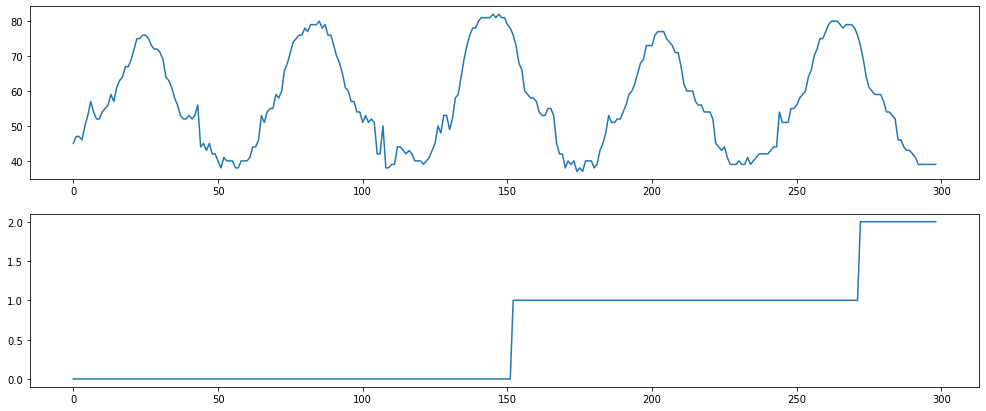

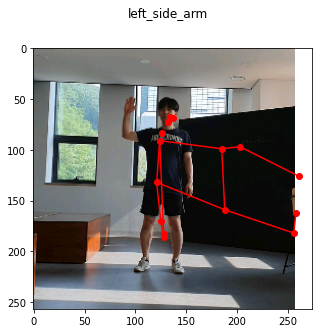

0 Camera Error: confidence error, 5 - 0 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 0 > 1
5 Camera Error: confidence error, 5 - 0 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 0 > 1
8 Camera Error: confidence error, 5 - 0 > 1
9 Camera Error: confidence error, 5 - 0 > 1
10 Camera Error: confidence error, 5 - 0 > 1
11 Camera Error: confidence error, 5 - 0 > 1
12 Camera Error: confidence error, 5 - 1 > 1
13 Camera Error: confidence error, 5 - 1 > 1
14 Camera Error: confidence error, 5 - 1 > 1
15 Camera Error: confidence error, 5 - 1 > 1
16 Camera Error: confidence error, 5 - 1 > 1
17 Camera Error: confidence error, 5 - 1 > 1
18 Camera Error: confidence error, 5 - 1 > 1
19 Camera Error: confidence error, 5 - 1 > 1
20 Camera Error: confidence error, 5 - 1 > 1
21 Camera Error: confidence error, 5 - 1 > 1
22 Camera Error: con

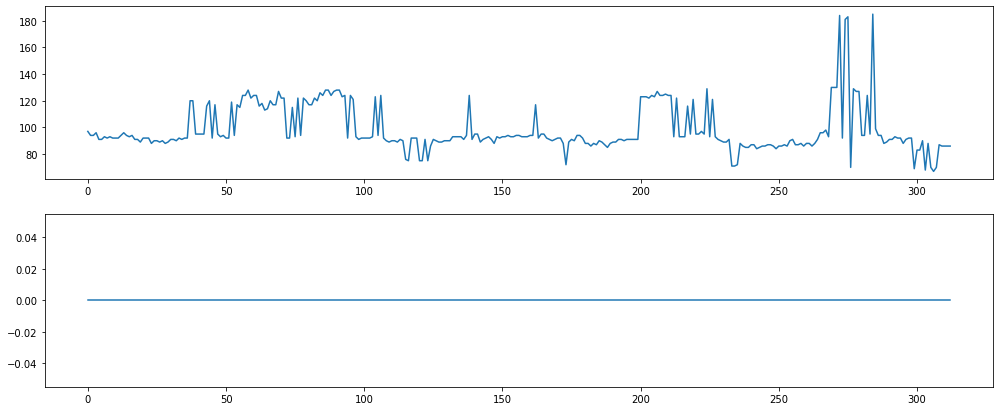

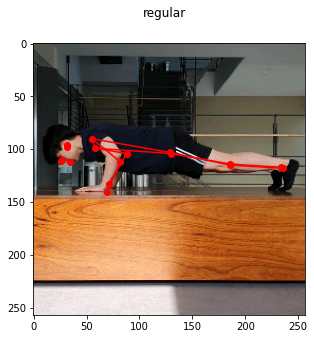

6 Pose Error: hip angle error, 181.9934609786503
31 Camera Error: shoulder distance error, 24.186773244895647
32 Pose Error: hip angle error, 186.37000069151293
33 Camera Error: shoulder distance error, 24.331050121192877
34 Camera Error: shoulder distance error, 24.331050121192877
35 Pose Error: hip angle error, 184.66232203640405
36 Pose Error: hip angle error, 181.35585997610642
37 Pose Error: hip angle error, 184.25383643611914
38 Pose Error: hip angle error, 183.41249984959424
39 Pose Error: hip angle error, 187.74410955435093
48 Pose Error: hip angle error, 180.31984117127806
65 Pose Error: knee angle error, 210.14836603200098
79 Pose Error: hip angle error, 181.8733643694708
82 Pose Error: hip angle error, 180.067169699026
97 Camera Error: shoulder distance error, 22.20360331117452
98 Camera Error: shoulder distance error, 23.194827009486403
100 Camera Error: shoulder distance error, 25.179356624028344
106 Pose Error: hip angle error, 182.91126246897076
107 Camera Error: shoulde

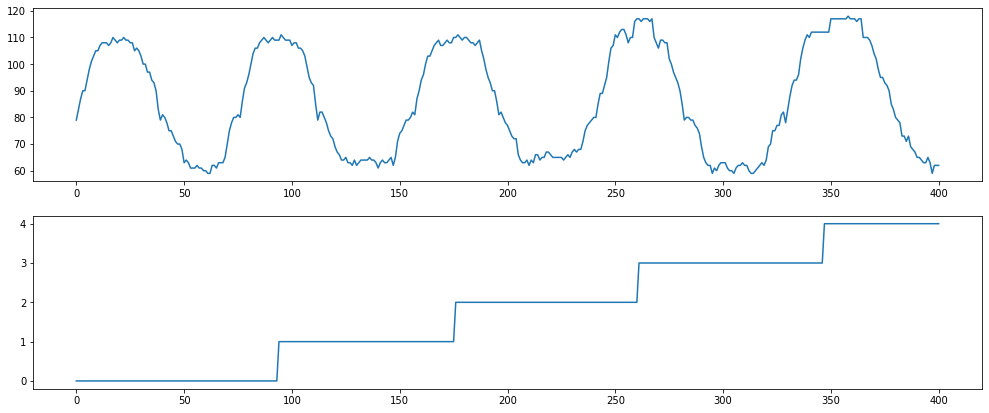

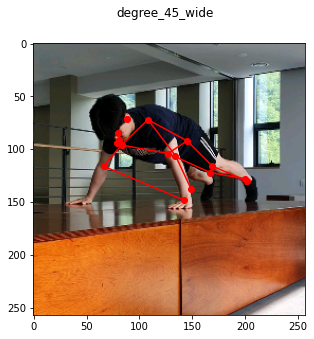

0 Camera Error: shoulder distance error, 34.058772731852805
1 Camera Error: shoulder distance error, 35.38361202590826
2 Camera Error: shoulder distance error, 35.38361202590826
3 Camera Error: shoulder distance error, 35.35533905932738
4 Camera Error: shoulder distance error, 34.655446902326915
5 Camera Error: shoulder distance error, 36.069377593742864
6 Camera Error: shoulder distance error, 37.48332962798263
7 Camera Error: shoulder distance error, 37.64306044943742
8 Camera Error: shoulder distance error, 34.713109915419565
9 Camera Error: shoulder distance error, 37.8021163428716
10 Camera Error: shoulder distance error, 35.608987629529715
11 Camera Error: shoulder distance error, 35.608987629529715
12 Camera Error: shoulder distance error, 32.202484376209235
13 Camera Error: shoulder distance error, 30.805843601498726
14 Camera Error: shoulder distance error, 24.20743687382041
15 Camera Error: shoulder distance error, 23.430749027719962
16 Camera Error: shoulder distance error, 

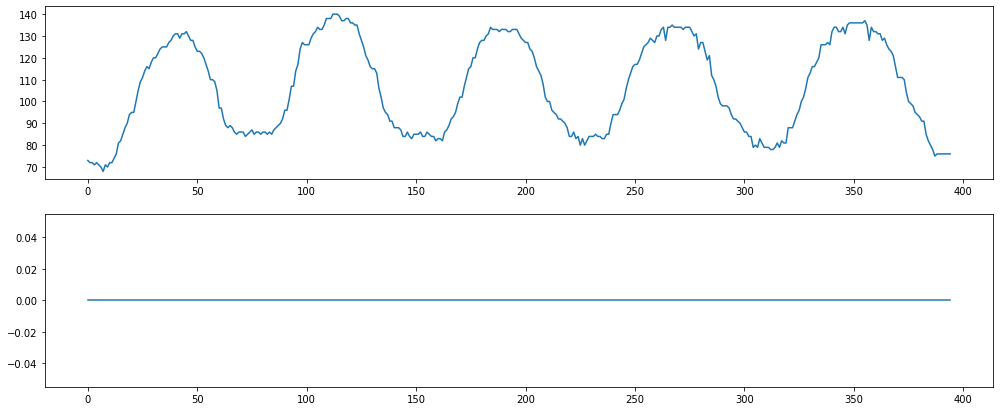

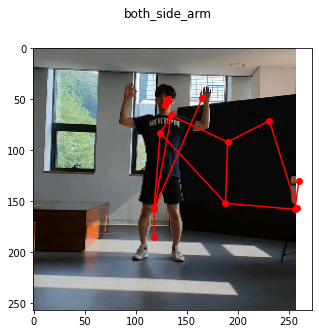

0 Camera Error: confidence error, 5 - 0 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 1 > 1
5 Camera Error: confidence error, 5 - 1 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 1 > 1
8 Camera Error: confidence error, 5 - 0 > 1
9 Camera Error: confidence error, 5 - 0 > 1
10 Camera Error: confidence error, 5 - 2 > 1
11 Camera Error: confidence error, 5 - 2 > 1
12 Camera Error: confidence error, 5 - 2 > 1
13 Camera Error: confidence error, 5 - 2 > 1
14 Camera Error: confidence error, 5 - 1 > 1
15 Camera Error: confidence error, 5 - 1 > 1
16 Camera Error: confidence error, 5 - 1 > 1
17 Camera Error: confidence error, 5 - 1 > 1
18 Camera Error: confidence error, 5 - 1 > 1
19 Camera Error: confidence error, 5 - 1 > 1
20 Camera Error: confidence error, 5 - 1 > 1
21 Camera Error: confidence error, 5 - 1 > 1
22 Camera Error: con

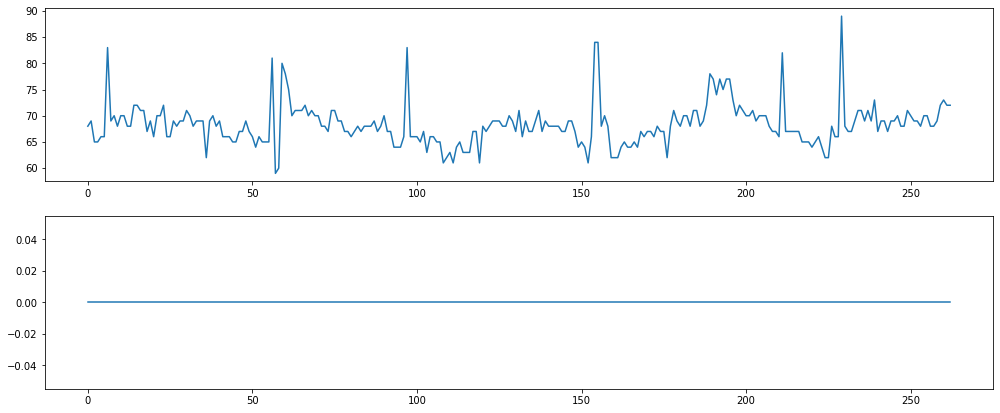

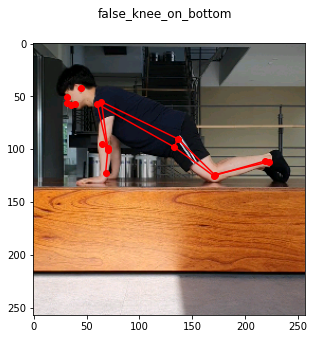

0 Pose Error: knee angle error, 239.52475507469578
1 Pose Error: knee angle error, 242.7341179726596
2 Pose Error: knee angle error, 237.40741852740075
3 Pose Error: knee angle error, 237.40741852740075
4 Pose Error: knee angle error, 237.41020442892918
5 Pose Error: knee angle error, 235.6496161250159
6 Pose Error: knee angle error, 233.29714496983686
7 Pose Error: knee angle error, 231.90436617072638
8 Pose Error: knee angle error, 230.91044680095808
9 Pose Error: knee angle error, 230.4403320310055
10 Pose Error: knee angle error, 229.63713835029768
11 Pose Error: knee angle error, 232.81933154821596
12 Pose Error: knee angle error, 232.72054581935436
13 Pose Error: knee angle error, 232.72054581935436
14 Pose Error: knee angle error, 237.75497408517907
15 Pose Error: knee angle error, 236.59640898429728
16 Pose Error: knee angle error, 235.91129309027593
17 Pose Error: knee angle error, 238.70936476825477
18 Pose Error: knee angle error, 237.51234813490936
19 Pose Error: knee angle

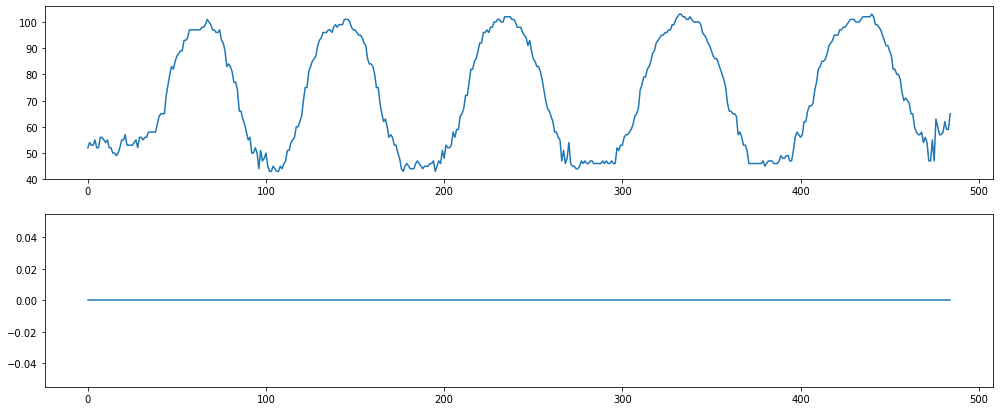

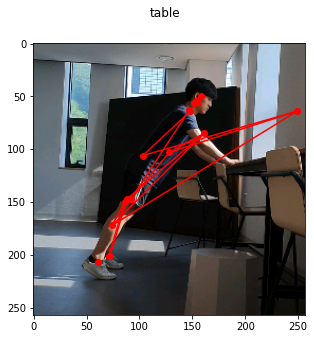

0 Camera Error: confidence error, 5 - 1 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 0 > 1
5 Camera Error: confidence error, 5 - 1 > 1
6 Camera Error: confidence error, 5 - 1 > 1
7 Camera Error: confidence error, 5 - 0 > 1
8 Camera Error: confidence error, 5 - 0 > 1
9 Camera Error: confidence error, 5 - 1 > 1
10 Camera Error: confidence error, 5 - 1 > 1
11 Camera Error: confidence error, 5 - 1 > 1
12 Camera Error: confidence error, 5 - 0 > 1
13 Camera Error: confidence error, 5 - 0 > 1
14 Camera Error: confidence error, 5 - 0 > 1
15 Camera Error: confidence error, 5 - 1 > 1
16 Camera Error: confidence error, 5 - 1 > 1
17 Camera Error: confidence error, 5 - 1 > 1
18 Camera Error: confidence error, 5 - 0 > 1
19 Camera Error: confidence error, 5 - 1 > 1
20 Camera Error: confidence error, 5 - 0 > 1
21 Camera Error: confidence error, 5 - 0 > 1
22 Camera Error: con

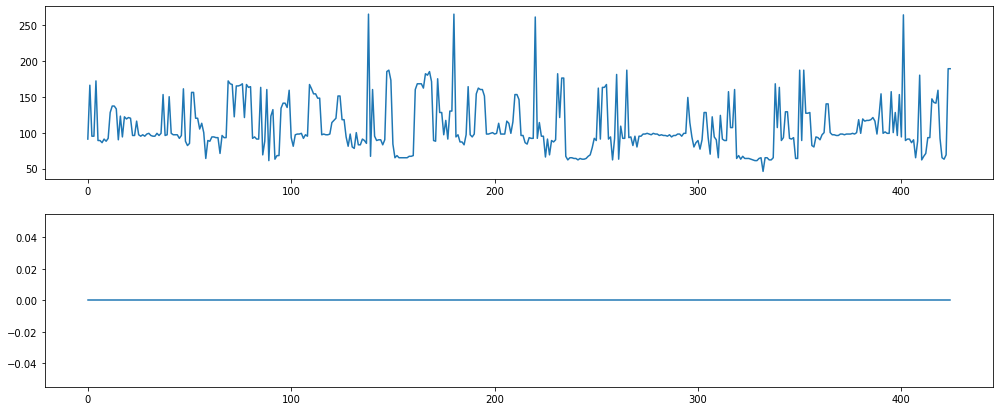

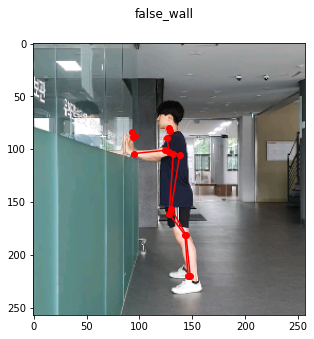

0 Camera Error: confidence error, 5 - 0 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 1 > 1
3 Camera Error: confidence error, 5 - 1 > 1
4 Camera Error: confidence error, 5 - 1 > 1
5 Camera Error: confidence error, 5 - 0 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 0 > 1
8 Camera Error: confidence error, 5 - 0 > 1
9 Camera Error: confidence error, 5 - 0 > 1
10 Camera Error: confidence error, 5 - 0 > 1
11 Camera Error: confidence error, 5 - 1 > 1
12 Camera Error: confidence error, 5 - 2 > 1
13 Camera Error: confidence error, 5 - 2 > 1
14 Camera Error: confidence error, 5 - 2 > 1
15 Camera Error: confidence error, 5 - 1 > 1
16 Camera Error: confidence error, 5 - 2 > 1
17 Camera Error: confidence error, 5 - 2 > 1
18 Camera Error: confidence error, 5 - 2 > 1
19 Camera Error: confidence error, 5 - 2 > 1
20 Camera Error: confidence error, 5 - 1 > 1
21 Camera Error: confidence error, 5 - 1 > 1
22 Camera Error: con

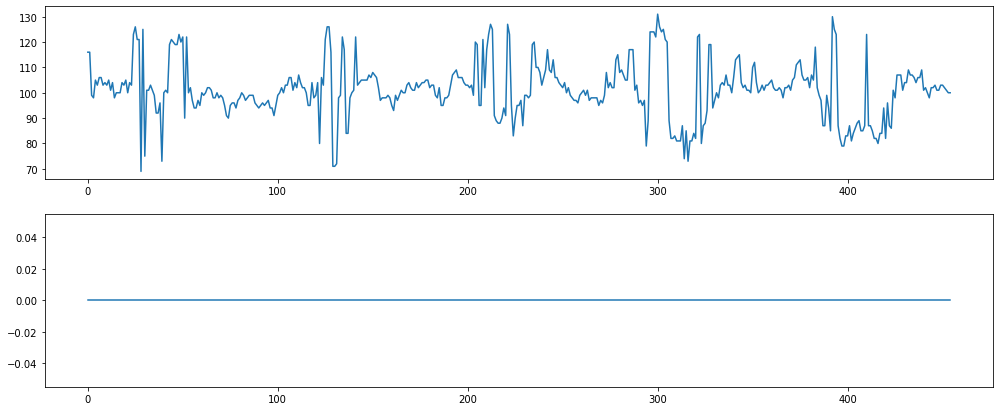

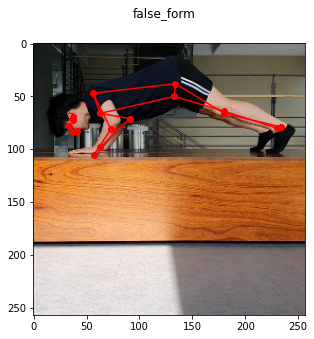

14 Camera Error: shoulder distance error, 21.840329667841555
15 Camera Error: shoulder distance error, 24.351591323771842
16 Camera Error: shoulder distance error, 24.515301344262525
17 Camera Error: shoulder distance error, 22.20360331117452
23 Camera Error: shoulder distance error, 22.20360331117452
31 Camera Error: shoulder distance error, 22.80350850198276
32 Camera Error: shoulder distance error, 22.80350850198276
59 Pose Error: hip angle error, 128.8298249049704
77 Camera Error: shoulder distance error, 25.298221281347036
78 Camera Error: shoulder distance error, 24.351591323771842
80 Camera Error: shoulder distance error, 23.08679276123039
85 Camera Error: shoulder distance error, 21.93171219946131
89 Camera Error: shoulder distance error, 23.194827009486403
90 Camera Error: shoulder distance error, 24.73863375370596
91 Camera Error: shoulder distance error, 24.73863375370596
92 Camera Error: shoulder distance error, 24.73863375370596
93 Camera Error: shoulder distance error, 23

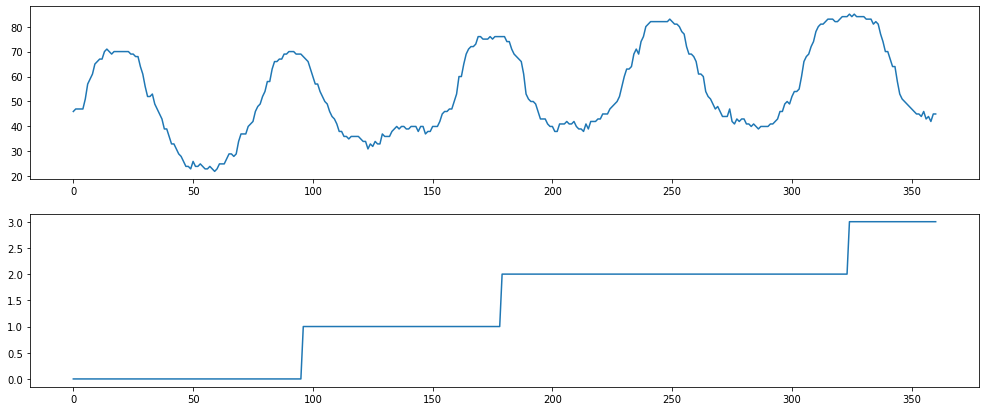

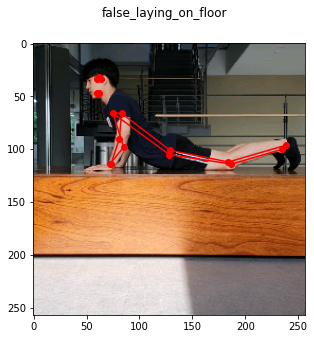

0 Pose Error: hip angle error, 208.38590264053906
1 Pose Error: hip angle error, 207.63818955328065
2 Pose Error: hip angle error, 207.63818955328065
3 Pose Error: hip angle error, 210.48894049983093
4 Pose Error: hip angle error, 205.95646942695691
5 Pose Error: hip angle error, 211.56897112931833
6 Pose Error: hip angle error, 218.30925360310266
7 Pose Error: hip angle error, 216.67117039761604
8 Pose Error: hip angle error, 214.91691366125394
9 Pose Error: hip angle error, 216.54375149088034
10 Pose Error: hip angle error, 215.9775636576059
11 Pose Error: hip angle error, 215.9775636576059
12 Pose Error: hip angle error, 217.21220856723363
13 Pose Error: hip angle error, 226.22837623488056
14 Pose Error: hip angle error, 225.09331551930492
15 Pose Error: hip angle error, 227.01283603968335
16 Pose Error: hip angle error, 219.76992374465706
17 Pose Error: hip angle error, 232.31087883375307
18 Pose Error: hip angle error, 225.75156651148217
19 Pose Error: hip angle error, 225.6182757

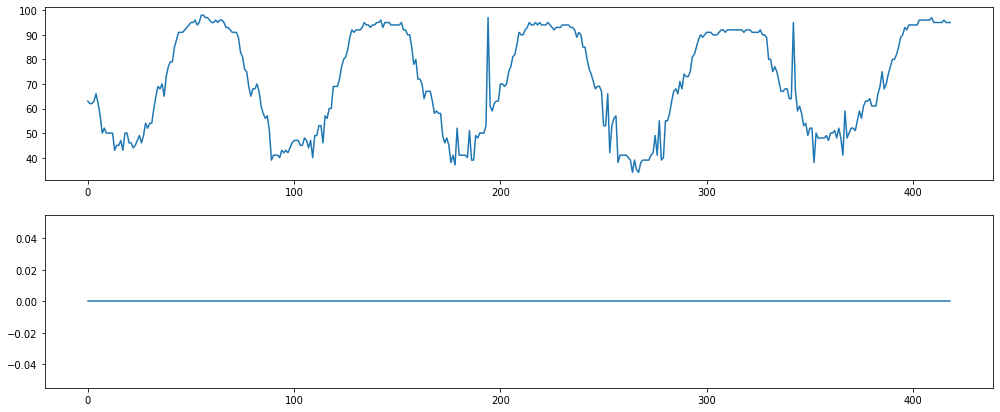

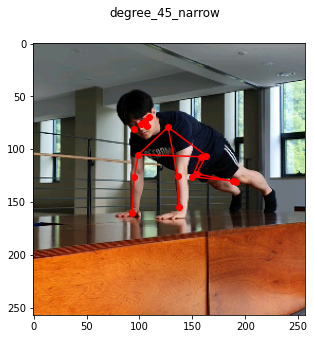

0 Camera Error: confidence error, 5 - 3 > 1
1 Camera Error: confidence error, 5 - 3 > 1
2 Camera Error: confidence error, 5 - 3 > 1
3 Camera Error: confidence error, 5 - 3 > 1
4 Camera Error: shoulder distance error, 38.2099463490856
5 Camera Error: shoulder distance error, 35.38361202590826
6 Camera Error: shoulder distance error, 42.80186911806539
7 Camera Error: shoulder distance error, 37.48332962798263
8 Camera Error: shoulder distance error, 37.48332962798263
9 Camera Error: confidence error, 5 - 3 > 1
10 Camera Error: shoulder distance error, 33.301651610693426
11 Camera Error: confidence error, 5 - 3 > 1
12 Camera Error: shoulder distance error, 30.4138126514911
13 Camera Error: confidence error, 5 - 3 > 1
14 Camera Error: confidence error, 5 - 3 > 1
15 Camera Error: shoulder distance error, 32.526911934581186
16 Camera Error: confidence error, 5 - 3 > 1
17 Camera Error: confidence error, 5 - 3 > 1
18 Camera Error: confidence error, 5 - 3 > 1
19 Camera Error: confidence error, 

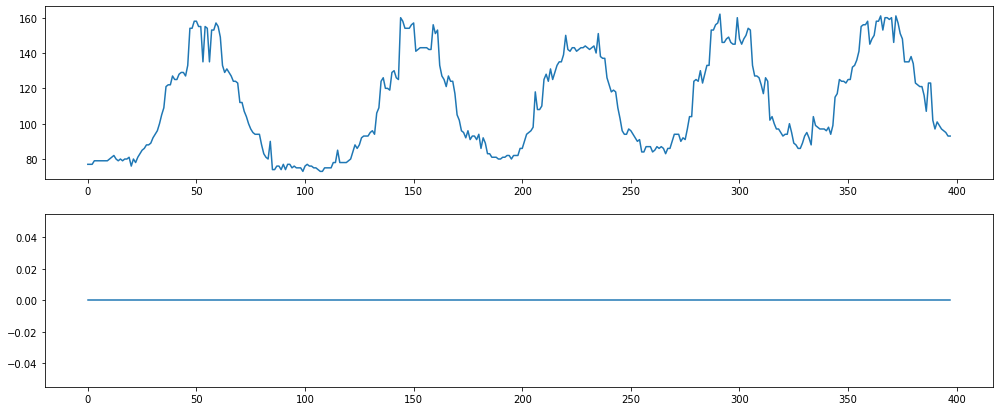

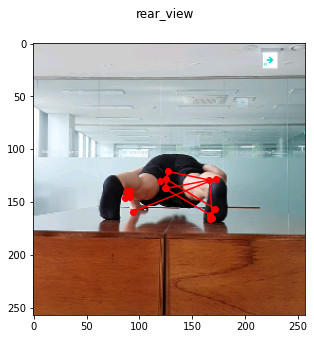

0 Camera Error: confidence error, 5 - 0 > 1
1 Camera Error: confidence error, 5 - 2 > 1
2 Camera Error: confidence error, 5 - 2 > 1
3 Camera Error: confidence error, 5 - 2 > 1
4 Camera Error: confidence error, 5 - 2 > 1
5 Camera Error: confidence error, 5 - 2 > 1
6 Camera Error: confidence error, 5 - 1 > 1
7 Camera Error: confidence error, 5 - 1 > 1
8 Camera Error: confidence error, 5 - 2 > 1
9 Camera Error: confidence error, 5 - 1 > 1
10 Camera Error: confidence error, 5 - 1 > 1
11 Camera Error: confidence error, 5 - 1 > 1
12 Camera Error: confidence error, 5 - 1 > 1
13 Camera Error: confidence error, 5 - 1 > 1
14 Camera Error: confidence error, 5 - 1 > 1
15 Camera Error: confidence error, 5 - 2 > 1
16 Camera Error: confidence error, 5 - 1 > 1
17 Camera Error: confidence error, 5 - 1 > 1
18 Camera Error: confidence error, 5 - 1 > 1
19 Camera Error: confidence error, 5 - 2 > 1
20 Camera Error: confidence error, 5 - 2 > 1
21 Camera Error: confidence error, 5 - 1 > 1
22 Camera Error: con

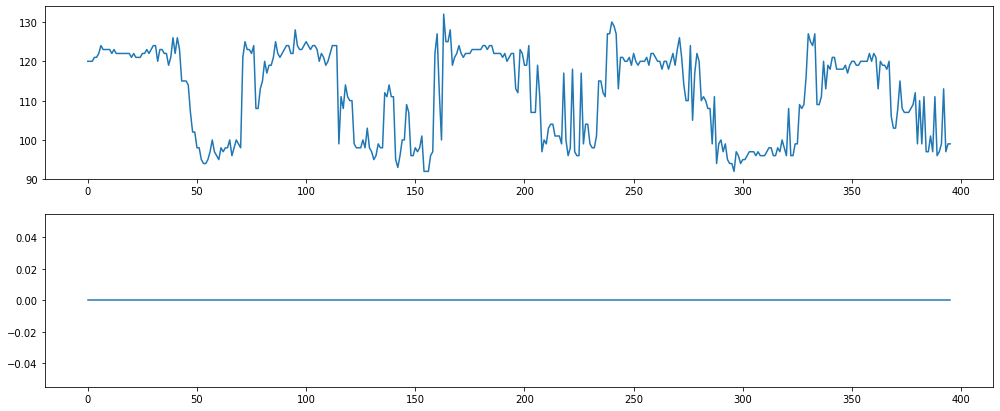

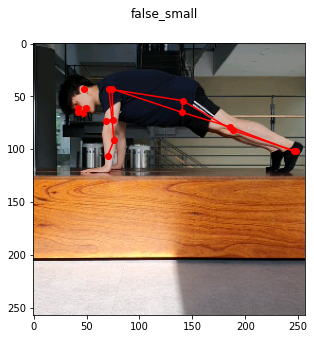

37 Camera Error: shoulder distance error, 22.135943621178654


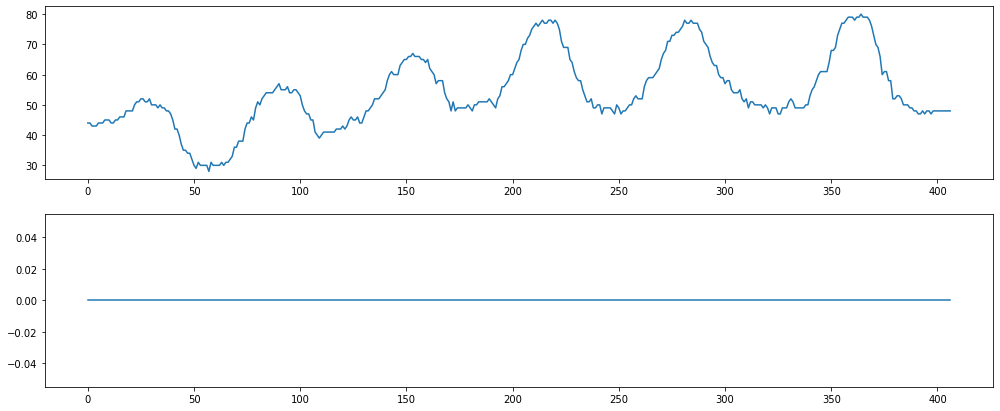

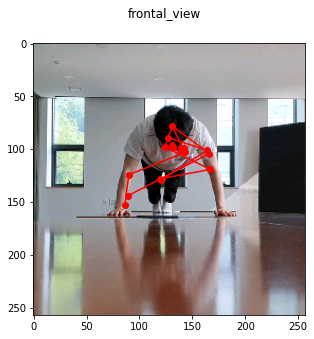

0 Camera Error: confidence error, 5 - 1 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 1 > 1
5 Camera Error: confidence error, 5 - 1 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 0 > 1
8 Camera Error: confidence error, 5 - 1 > 1
9 Camera Error: confidence error, 5 - 0 > 1
10 Camera Error: confidence error, 5 - 1 > 1
11 Camera Error: confidence error, 5 - 1 > 1
12 Camera Error: confidence error, 5 - 1 > 1
13 Camera Error: confidence error, 5 - 0 > 1
14 Camera Error: confidence error, 5 - 0 > 1
15 Camera Error: confidence error, 5 - 0 > 1
16 Camera Error: confidence error, 5 - 0 > 1
17 Camera Error: confidence error, 5 - 0 > 1
18 Camera Error: confidence error, 5 - 0 > 1
19 Camera Error: confidence error, 5 - 1 > 1
20 Camera Error: confidence error, 5 - 1 > 1
21 Camera Error: confidence error, 5 - 0 > 1
22 Camera Error: con

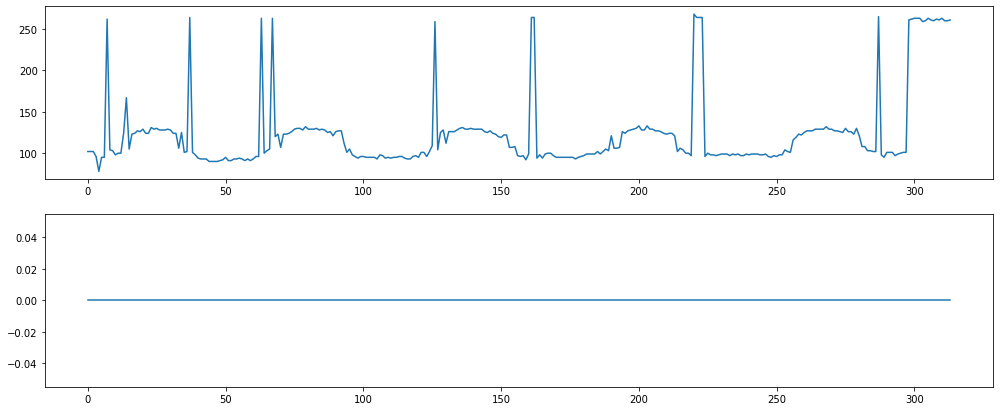

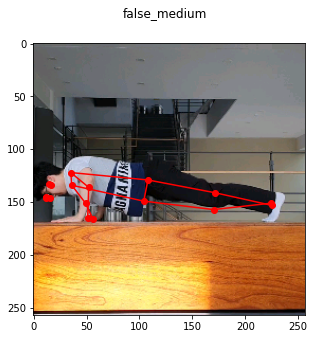

23 Camera Error: confidence error, 5 - 3 > 1
25 Camera Error: confidence error, 5 - 3 > 1
26 Camera Error: confidence error, 5 - 3 > 1
50 Pose Error: hip angle error, 180.6924345538548
51 Camera Error: shoulder distance error, 23.194827009486403
61 Camera Error: confidence error, 5 - 3 > 1
93 Pose Error: hip angle error, 180.20936245251667
99 Pose Error: hip angle error, 180.12404105293794
138 Camera Error: shoulder distance error, 25.179356624028344
139 Camera Error: shoulder distance error, 23.345235059857504
141 Camera Error: shoulder distance error, 23.769728648009426
147 Pose Error: hip angle error, 180.46962701969025
148 Camera Error: shoulder distance error, 24.515301344262525


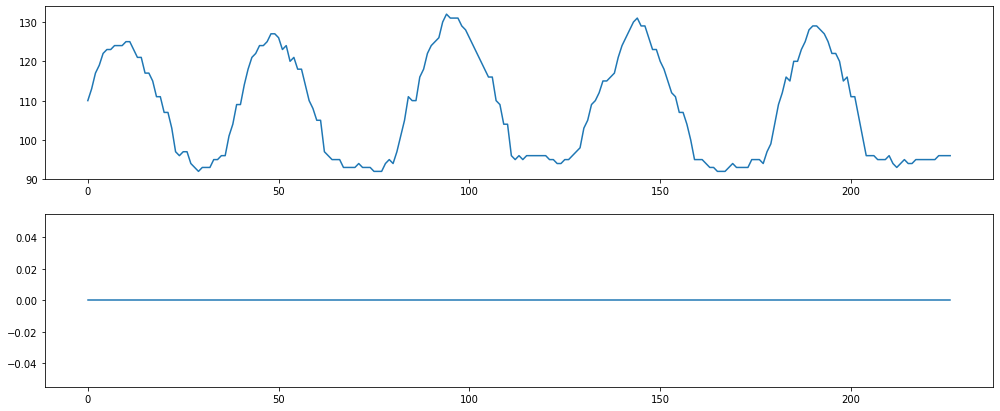

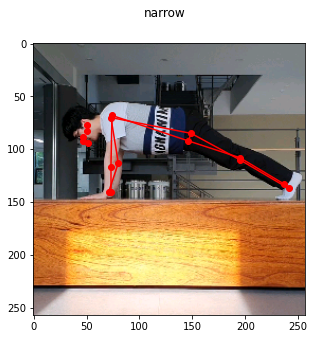

23 Pose Error: hip angle error, 180.1539171032591
24 Pose Error: hip angle error, 181.57474506575315
25 Pose Error: hip angle error, 184.34451398396513
38 Pose Error: hip angle error, 180.20139031126803
41 Pose Error: hip angle error, 182.7839644407722
42 Pose Error: hip angle error, 182.7839644407722
43 Pose Error: hip angle error, 182.81635143237693
44 Pose Error: hip angle error, 184.32959105858674
59 Camera Error: shoulder distance error, 23.194827009486403
68 Camera Error: shoulder distance error, 22.360679774997898
90 Pose Error: hip angle error, 181.0724557177013
91 Pose Error: hip angle error, 186.15985013600044
92 Pose Error: hip angle error, 186.15985013600044
93 Pose Error: hip angle error, 186.38738112124926
94 Pose Error: hip angle error, 186.8867664386375
96 Pose Error: hip angle error, 182.35666593205903
98 Pose Error: hip angle error, 182.20909181019695
99 Pose Error: hip angle error, 181.57495803825594
100 Pose Error: hip angle error, 181.07769003439867
101 Pose Error:

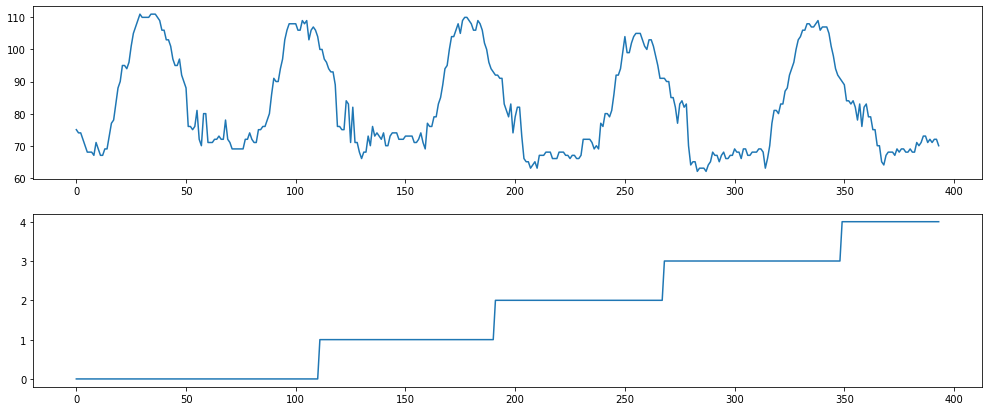

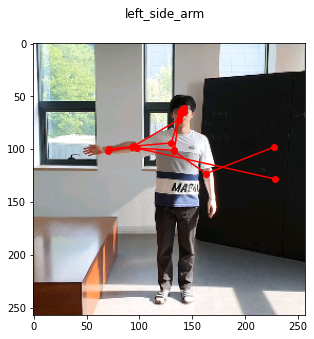

0 Camera Error: confidence error, 5 - 1 > 1
1 Camera Error: confidence error, 5 - 2 > 1
2 Camera Error: confidence error, 5 - 1 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 1 > 1
5 Camera Error: confidence error, 5 - 1 > 1
6 Camera Error: confidence error, 5 - 1 > 1
7 Camera Error: confidence error, 5 - 1 > 1
8 Camera Error: confidence error, 5 - 1 > 1
9 Camera Error: confidence error, 5 - 2 > 1
10 Camera Error: confidence error, 5 - 1 > 1
11 Camera Error: confidence error, 5 - 1 > 1
12 Camera Error: confidence error, 5 - 2 > 1
13 Camera Error: confidence error, 5 - 1 > 1
14 Camera Error: confidence error, 5 - 2 > 1
15 Camera Error: confidence error, 5 - 2 > 1
16 Camera Error: confidence error, 5 - 2 > 1
17 Camera Error: confidence error, 5 - 2 > 1
18 Camera Error: confidence error, 5 - 2 > 1
19 Camera Error: confidence error, 5 - 2 > 1
20 Camera Error: confidence error, 5 - 1 > 1
21 Camera Error: confidence error, 5 - 2 > 1
22 Camera Error: con

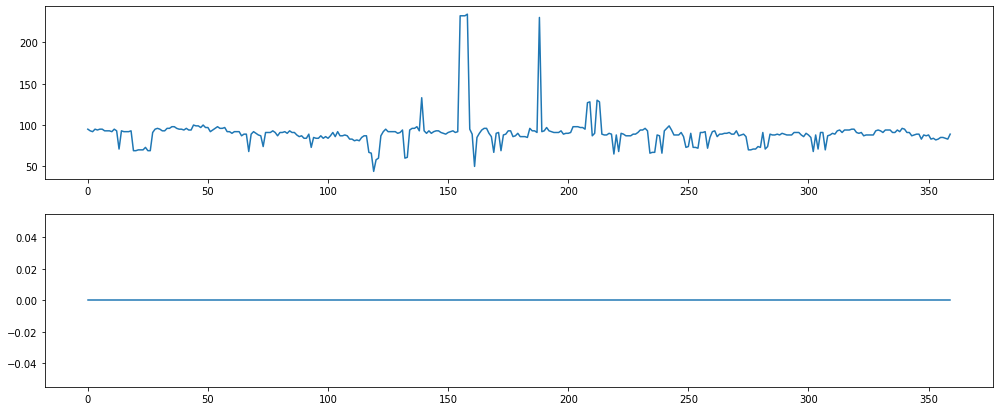

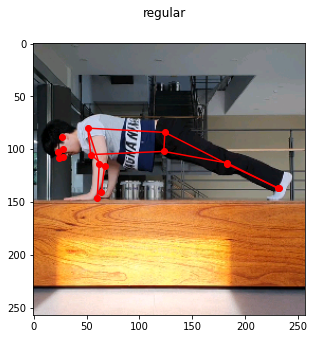

4 Camera Error: shoulder distance error, 25.179356624028344
9 Pose Error: hip angle error, 180.9425152628906
10 Pose Error: hip angle error, 180.24696303742877
41 Camera Error: confidence error, 5 - 3 > 1
48 Camera Error: confidence error, 5 - 3 > 1
73 Camera Error: shoulder distance error, 24.08318915758459
74 Camera Error: shoulder distance error, 25.079872407968907
75 Camera Error: shoulder distance error, 26.076809620810597
76 Camera Error: shoulder distance error, 26.076809620810597
77 Camera Error: shoulder distance error, 25.079872407968907
78 Camera Error: shoulder distance error, 25.179356624028344
83 Pose Error: hip angle error, 181.53263179035838
87 Pose Error: hip angle error, 180.19066744763032
95 Camera Error: confidence error, 5 - 3 > 1
96 Camera Error: confidence error, 5 - 3 > 1
101 Camera Error: confidence error, 5 - 3 > 1
102 Camera Error: confidence error, 5 - 3 > 1
112 Camera Error: confidence error, 5 - 3 > 1
125 Pose Error: hip angle error, 183.7663879709669
126 

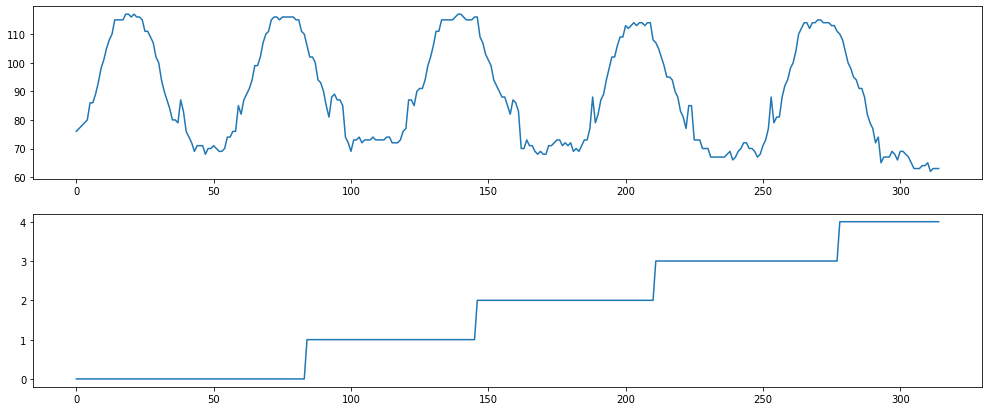

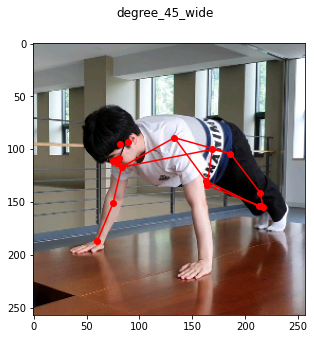

0 Camera Error: confidence error, 5 - 3 > 1
1 Camera Error: confidence error, 5 - 3 > 1
2 Camera Error: confidence error, 5 - 3 > 1
3 Camera Error: confidence error, 5 - 3 > 1
4 Camera Error: confidence error, 5 - 3 > 1
5 Camera Error: confidence error, 5 - 3 > 1
6 Camera Error: confidence error, 5 - 3 > 1
7 Camera Error: confidence error, 5 - 3 > 1
8 Camera Error: confidence error, 5 - 3 > 1
9 Camera Error: confidence error, 5 - 3 > 1
10 Camera Error: confidence error, 5 - 3 > 1
11 Camera Error: confidence error, 5 - 3 > 1
12 Camera Error: confidence error, 5 - 3 > 1
13 Camera Error: confidence error, 5 - 3 > 1
14 Camera Error: shoulder distance error, 29.832867780352597
15 Camera Error: shoulder distance error, 22.02271554554524
16 Camera Error: shoulder distance error, 22.02271554554524
17 Camera Error: shoulder distance error, 21.18962010041709
18 Camera Error: shoulder distance error, 24.041630560342615
19 Camera Error: confidence error, 5 - 3 > 1
20 Camera Error: shoulder distanc

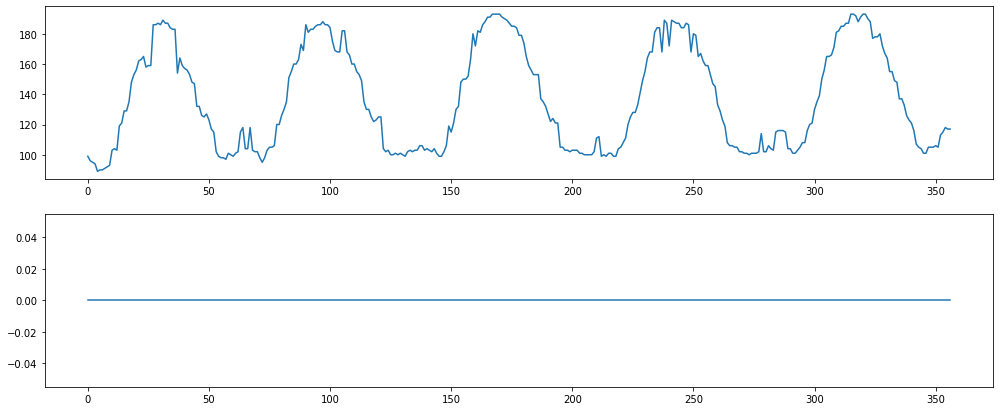

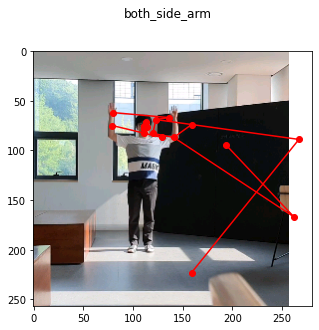

0 Camera Error: confidence error, 5 - 2 > 1
1 Camera Error: confidence error, 5 - 1 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 0 > 1
5 Camera Error: confidence error, 5 - 0 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 0 > 1
8 Camera Error: confidence error, 5 - 0 > 1
9 Camera Error: confidence error, 5 - 0 > 1
10 Camera Error: confidence error, 5 - 0 > 1
11 Camera Error: confidence error, 5 - 0 > 1
12 Camera Error: confidence error, 5 - 0 > 1
13 Camera Error: confidence error, 5 - 0 > 1
14 Camera Error: confidence error, 5 - 0 > 1
15 Camera Error: confidence error, 5 - 0 > 1
16 Camera Error: confidence error, 5 - 1 > 1
17 Camera Error: confidence error, 5 - 1 > 1
18 Camera Error: confidence error, 5 - 2 > 1
19 Camera Error: confidence error, 5 - 1 > 1
20 Camera Error: confidence error, 5 - 1 > 1
21 Camera Error: confidence error, 5 - 1 > 1
22 Camera Error: con

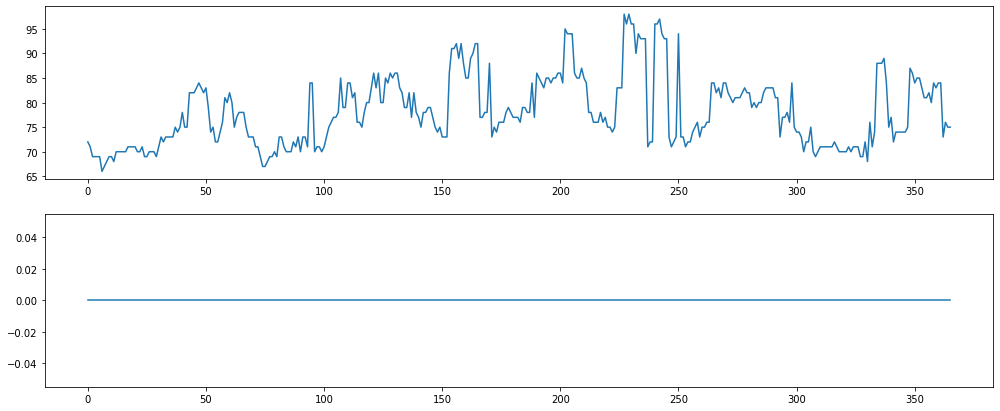

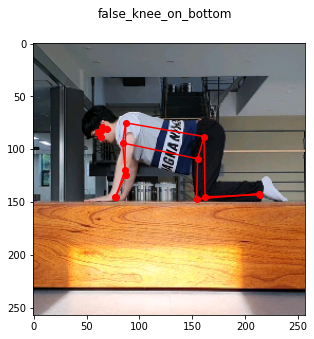

0 Pose Error: hip angle error, 92.63329844653346
1 Pose Error: hip angle error, 99.09027692082232
2 Pose Error: hip angle error, 96.21897988122758
3 Pose Error: hip angle error, 100.96889019516136
4 Pose Error: hip angle error, 100.96889019516136
5 Pose Error: hip angle error, 97.94959642622855
6 Pose Error: hip angle error, 96.27783305740553
7 Pose Error: hip angle error, 99.92147874622353
8 Pose Error: hip angle error, 101.33465379256944
9 Pose Error: hip angle error, 100.26830579801025
10 Pose Error: hip angle error, 92.54056051745665
11 Pose Error: hip angle error, 97.93099993888642
12 Pose Error: hip angle error, 101.82774880600117
13 Pose Error: hip angle error, 99.93888295028904
14 Pose Error: hip angle error, 99.93888295028904
15 Pose Error: hip angle error, 95.41444441071218
16 Pose Error: hip angle error, 95.74261453812866
17 Pose Error: hip angle error, 94.36693907871995
18 Pose Error: hip angle error, 97.10450228622194
19 Pose Error: hip angle error, 98.15930881499473
20 Po

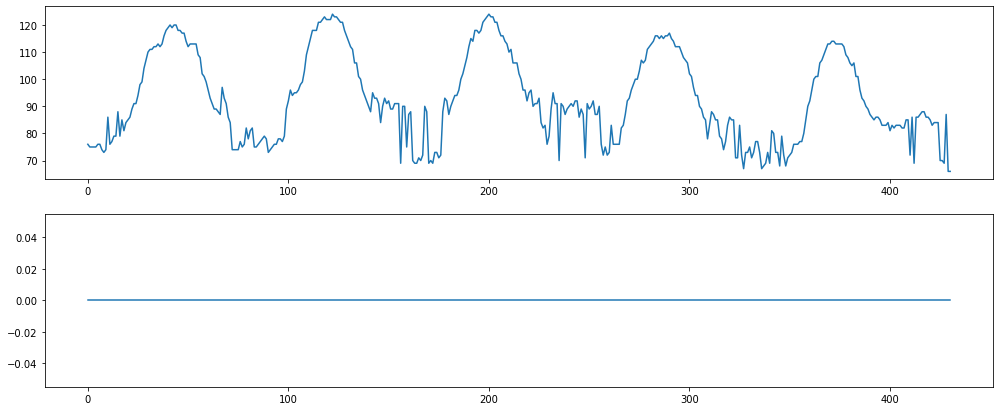

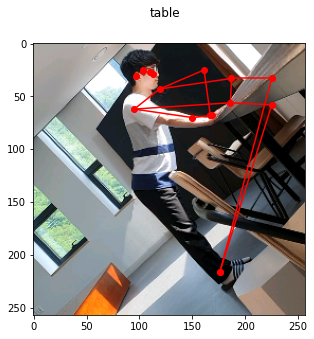

0 Camera Error: confidence error, 5 - 0 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 0 > 1
5 Camera Error: confidence error, 5 - 0 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 0 > 1
8 Camera Error: confidence error, 5 - 0 > 1
9 Camera Error: confidence error, 5 - 0 > 1
10 Camera Error: confidence error, 5 - 0 > 1
11 Camera Error: confidence error, 5 - 0 > 1
12 Camera Error: confidence error, 5 - 0 > 1
13 Camera Error: confidence error, 5 - 0 > 1
14 Camera Error: confidence error, 5 - 0 > 1
15 Camera Error: confidence error, 5 - 0 > 1
16 Camera Error: confidence error, 5 - 0 > 1
17 Camera Error: confidence error, 5 - 0 > 1
18 Camera Error: confidence error, 5 - 0 > 1
19 Camera Error: confidence error, 5 - 0 > 1
20 Camera Error: confidence error, 5 - 0 > 1
21 Camera Error: confidence error, 5 - 0 > 1
22 Camera Error: con

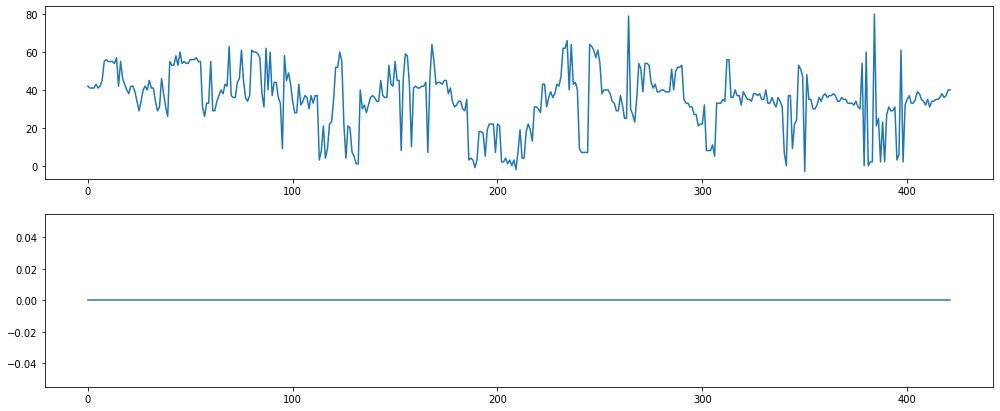

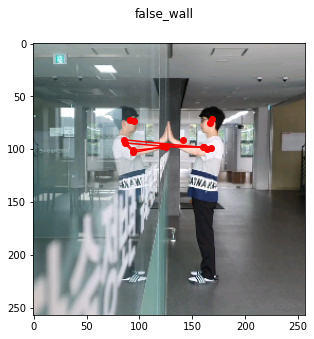

0 Camera Error: confidence error, 5 - 3 > 1
1 Camera Error: confidence error, 5 - 1 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 0 > 1
5 Camera Error: confidence error, 5 - 0 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 1 > 1
8 Camera Error: confidence error, 5 - 1 > 1
9 Camera Error: confidence error, 5 - 2 > 1
10 Camera Error: confidence error, 5 - 3 > 1
11 Camera Error: confidence error, 5 - 2 > 1
12 Camera Error: confidence error, 5 - 1 > 1
13 Camera Error: confidence error, 5 - 1 > 1
14 Camera Error: confidence error, 5 - 0 > 1
15 Camera Error: confidence error, 5 - 0 > 1
16 Camera Error: confidence error, 5 - 0 > 1
17 Camera Error: confidence error, 5 - 0 > 1
18 Camera Error: confidence error, 5 - 1 > 1
19 Camera Error: confidence error, 5 - 0 > 1
20 Camera Error: confidence error, 5 - 1 > 1
21 Camera Error: confidence error, 5 - 0 > 1
22 Camera Error: con

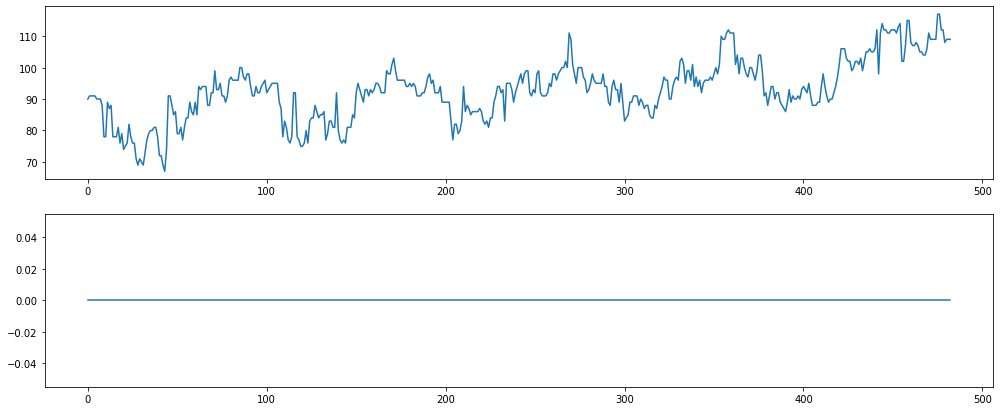

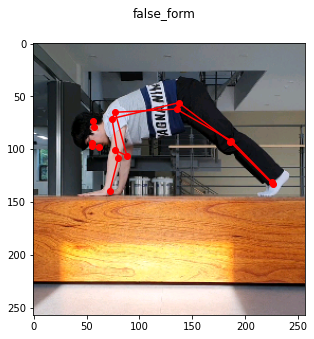

0 Pose Error: hip angle error, 127.50873772187136
1 Pose Error: hip angle error, 128.0678467389134
2 Pose Error: hip angle error, 128.18178542834815
3 Pose Error: hip angle error, 130.91287571405255
4 Pose Error: hip angle error, 129.5509740568393
5 Pose Error: hip angle error, 129.44988729611262
6 Pose Error: hip angle error, 129.44988729611262
7 Pose Error: hip angle error, 128.63789782322198
8 Pose Error: hip angle error, 126.74458023874938
9 Pose Error: hip angle error, 126.27682337369056
10 Pose Error: hip angle error, 127.33595045774798
11 Pose Error: hip angle error, 126.24938999801009
12 Pose Error: hip angle error, 130.06344215206755
13 Pose Error: hip angle error, 126.65260502057562
14 Pose Error: hip angle error, 127.22262416640913
15 Pose Error: hip angle error, 132.4778238135426
16 Pose Error: hip angle error, 132.4778238135426
21 Camera Error: shoulder distance error, 21.587033144922902
24 Camera Error: shoulder distance error, 23.259406699226016
25 Camera Error: shoulder

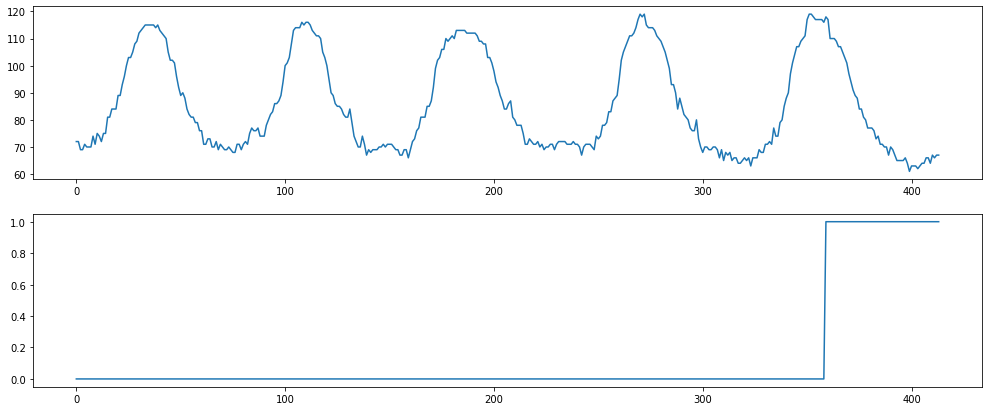

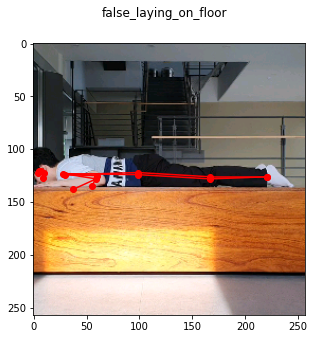

0 Pose Error: body angle error, 4.561361495782787
1 Pose Error: body angle error, 4.5972304018752
2 Pose Error: body angle error, 4.040131174909121
3 Pose Error: body angle error, 4.621933252521177
4 Pose Error: body angle error, 4.621933252521177
5 Pose Error: body angle error, 4.621933252521177
6 Pose Error: body angle error, 4.594855329152819
18 Pose Error: body angle error, 3.3674117096494713
19 Pose Error: body angle error, 3.378883818326885
20 Pose Error: body angle error, 3.3407244744363207
22 Pose Error: body angle error, 4.23604193386878
23 Pose Error: body angle error, 4.189546068688849
24 Pose Error: body angle error, 4.189546068688849
28 Pose Error: hip angle error, 185.67566581825284
29 Pose Error: hip angle error, 182.99147805671842
30 Pose Error: hip angle error, 191.25607847170963
31 Pose Error: hip angle error, 194.01861942064687
32 Pose Error: hip angle error, 197.38341085218087
33 Pose Error: hip angle error, 203.2948750625697
34 Pose Error: hip angle error, 203.2948

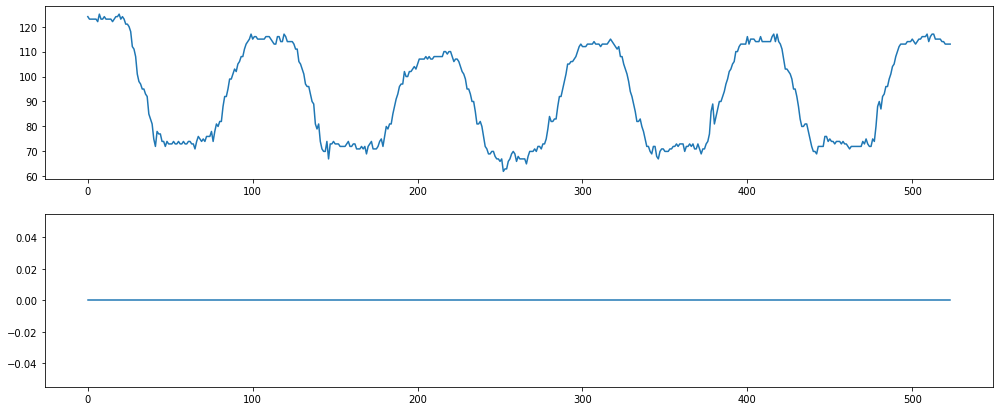

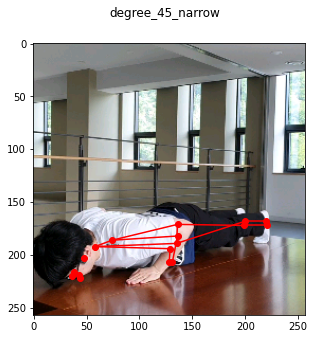

0 Camera Error: confidence error, 5 - 3 > 1
3 Camera Error: confidence error, 5 - 3 > 1
4 Camera Error: confidence error, 5 - 3 > 1
5 Camera Error: confidence error, 5 - 3 > 1
6 Camera Error: shoulder distance error, 35.22782990761707
7 Camera Error: confidence error, 5 - 2 > 1
8 Camera Error: shoulder distance error, 38.3275357934736
9 Camera Error: confidence error, 5 - 3 > 1
10 Camera Error: confidence error, 5 - 3 > 1
11 Camera Error: confidence error, 5 - 3 > 1
12 Camera Error: shoulder distance error, 39.81205847478876
13 Camera Error: shoulder distance error, 31.016124838541646
14 Camera Error: shoulder distance error, 31.016124838541646
15 Camera Error: shoulder distance error, 36.68787265568828
16 Camera Error: shoulder distance error, 37.64306044943742
17 Camera Error: shoulder distance error, 41.23105625617661
18 Camera Error: shoulder distance error, 42.42640687119285
19 Camera Error: shoulder distance error, 44.68780594300866
20 Camera Error: shoulder distance error, 41.23

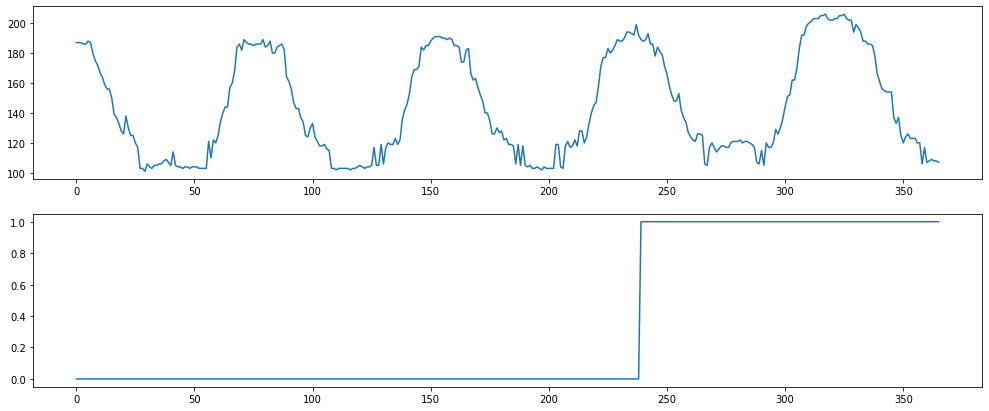

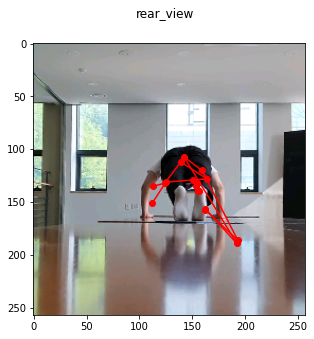

0 Camera Error: confidence error, 5 - 0 > 1
1 Camera Error: confidence error, 5 - 0 > 1
2 Camera Error: confidence error, 5 - 0 > 1
3 Camera Error: confidence error, 5 - 0 > 1
4 Camera Error: confidence error, 5 - 0 > 1
5 Camera Error: confidence error, 5 - 0 > 1
6 Camera Error: confidence error, 5 - 0 > 1
7 Camera Error: confidence error, 5 - 0 > 1
8 Camera Error: confidence error, 5 - 0 > 1
9 Camera Error: confidence error, 5 - 0 > 1
10 Camera Error: confidence error, 5 - 0 > 1
11 Camera Error: confidence error, 5 - 0 > 1
12 Camera Error: confidence error, 5 - 0 > 1
13 Camera Error: confidence error, 5 - 0 > 1
14 Camera Error: confidence error, 5 - 0 > 1
15 Camera Error: confidence error, 5 - 0 > 1
16 Camera Error: confidence error, 5 - 0 > 1
17 Camera Error: confidence error, 5 - 0 > 1
18 Camera Error: confidence error, 5 - 0 > 1
19 Camera Error: confidence error, 5 - 0 > 1
20 Camera Error: confidence error, 5 - 0 > 1
21 Camera Error: confidence error, 5 - 0 > 1
22 Camera Error: con

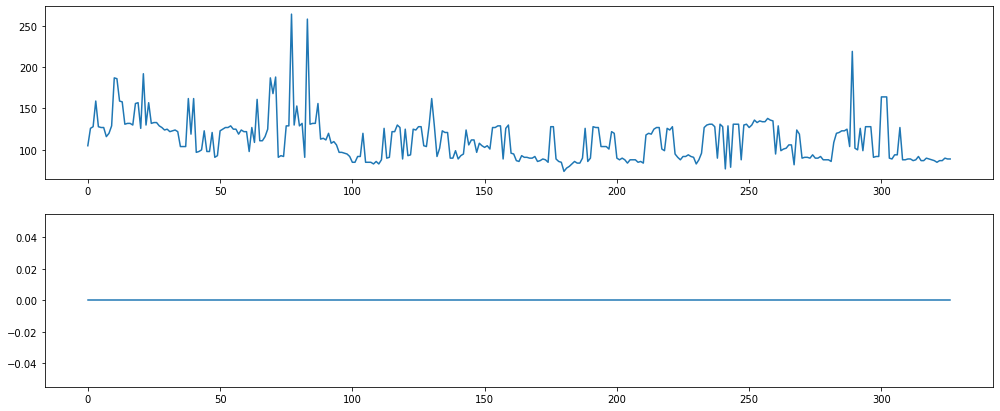

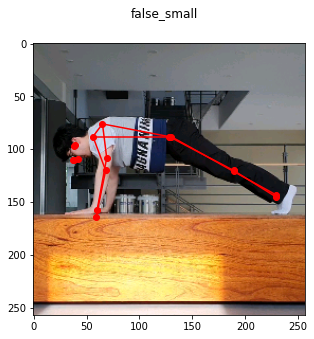

10 Camera Error: shoulder distance error, 26.30589287593181
11 Camera Error: shoulder distance error, 25.495097567963924
70 Camera Error: shoulder distance error, 28.0178514522438
71 Camera Error: shoulder distance error, 27.16615541441225
72 Camera Error: shoulder distance error, 25.179356624028344
73 Camera Error: shoulder distance error, 27.0
82 Camera Error: shoulder distance error, 25.079872407968907
87 Camera Error: shoulder distance error, 24.73863375370596
88 Camera Error: shoulder distance error, 23.345235059857504
109 Camera Error: shoulder distance error, 28.0178514522438
110 Camera Error: shoulder distance error, 24.08318915758459
112 Camera Error: shoulder distance error, 24.186773244895647
122 Camera Error: shoulder distance error, 23.08679276123039
131 Camera Error: shoulder distance error, 25.298221281347036
132 Camera Error: shoulder distance error, 24.041630560342615
138 Camera Error: shoulder distance error, 23.769728648009426
139 Camera Error: shoulder distance erro

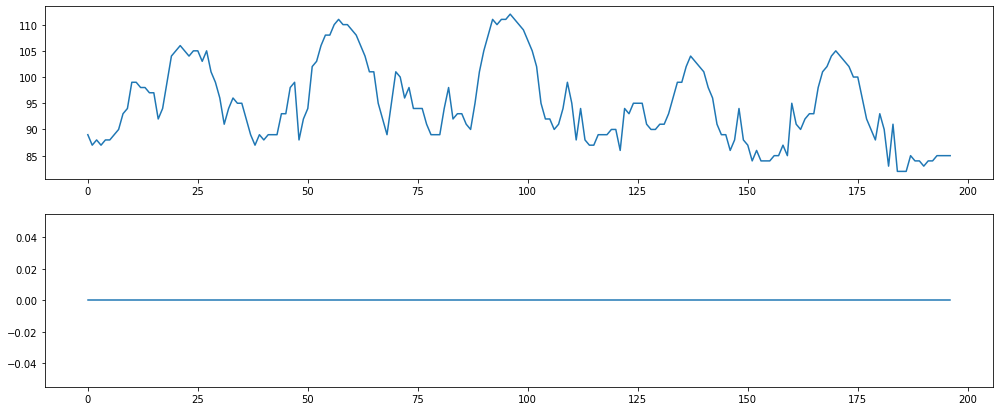

In [11]:
from scipy.signal import medfilt


def get_xyscore(inference_result, body_part):
    return inference_result[BODY_PART_TO_IDX[body_part]]

for key, value in pos_sequences.items():
    person, pushup_type = key
#     if key != ('changmin', 'regular'):
#         continue
#     if not pushup_type in ['regular', 'false_medium', 'false_small', 'narrow']:
#         continue
        
    # Draw sample image
    img = get_image(person, pushup_type, 120)
    fig, ax = plt.subplots(figsize=(5,5))
    fig.suptitle(pushup_type)
    ax.imshow(img)
    draw_skeleton(inference(img), ax)
    plt.show()
    
    
    # Draw y_shoulder and counts
    fig, ax = plt.subplots(2, figsize=(17,7))
    
    pushup_counter = PushupCounter()
    counts = []
    y_shoulders = []
    for idx, inference_result in enumerate(value):
        count = pushup_counter.count(inference_result, idx)
        y_shoulder = get_xyscore(inference_result, 'LEFT_SHOULDER')[1]
        counts.append(count)
        y_shoulders.append(y_shoulder)
    ax[0].plot(y_shoulders)
    ax[1].plot(counts)
    plt.show()